 # Omega aragonite calculations (Terminos lagoon 2024)

In [1]:
# Import packages
import pandas as pd
import PyCO2SYS as pyco2
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro

- Read Terminos lagoon csv data file 



In [2]:
# Function to read in csv file
def read_csv(file):
    """
    Read in csv file and return pandas dataframe
    """
    df = pd.read_csv(file, sep=",", header=0,  decimal=".", encoding='utf-8')
    return df

In [3]:
# define file path 
terminos_ta_dic_data_path = "../data/terminoslagoon_TA_DIC_2024_RawData.csv"

# Read in data
terminos_ta_dic_data = read_csv(terminos_ta_dic_data_path)

# Copy data to new dataframe
terminos_ta_dic = terminos_ta_dic_data.copy()

_________________

## Calcium salinity linear relationship over saturation aragonite in Terminos Lagoon

In [4]:
# Copy data to new dataframe
terminos_inorganic_carbon = terminos_ta_dic.copy()

# Create dictionary with data configuration for PyCO2SYS. 
# For more information on the parameters see Humphreys et al (2022)
my_co2sys_params_dic_ta_config = {
    # DIC measured in the lab in μmol/kg-sw
    "par1": terminos_inorganic_carbon["DIC_micromol_kg"],
    # TA measured in the lab, Total scale
    "par2": terminos_inorganic_carbon["TA_micromol_kg"],
    "par1_type": 2,         # tell PyCO2SYS: "par2 is a DIC value"
    "par2_type": 1,         # tell PyCO2SYS: "par1 is a TA value"
    # Fields conditions
    "salinity": terminos_inorganic_carbon["Sal_psu"],  # in-situ salinity in PSU
    # in-situ temperature (output conditions) in °C
    "temperature_out": terminos_inorganic_carbon["Temp_C"],
    "pressure_out": 0.0,
    # Settings
    "opt_pH_scale": 1,     # Total pH (Wolf-Gladrow et al. 2007)
    "opt_k_carbonic": 15,     # 0 < T < 50 °C, 1 < S < 50, Seawater scale, real seawater (Millero F.J. 2010)
    "temperature": 25      # lab temperature (input conditions) in °C
}

In [5]:
# Run PyCO2SYS to calculate the carbonate system parameters
terminos_inorganic_carbon_results= pyco2.sys(**my_co2sys_params_dic_ta_config)

The R-squared value for (Total Ca <= 7300) is: 0.7158975909744342
The R-squared value for (Total Ca  > 7300) is: 0.08018744295291395


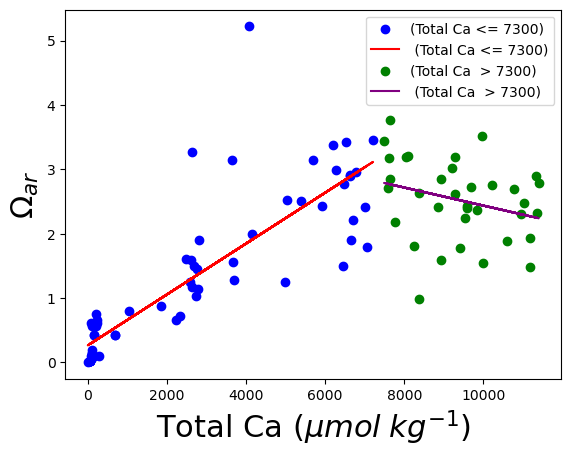

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def process_segment(total_calcium, saturation_aragonite, mask, color_data, color_fit, label):
    # Segment the data
    total_calcium_seg, saturation_aragonite_seg = total_calcium[mask], saturation_aragonite[mask]

    # Calculate the coefficients of the linear relationship
    coefficients = np.polyfit(total_calcium_seg, saturation_aragonite_seg, 1)

    # Generate y-values based on the linear relationship
    y_values = coefficients[0] * total_calcium_seg + coefficients[1]

    # Calculate the correlation coefficient
    r_squared = np.corrcoef(total_calcium_seg, saturation_aragonite_seg)[0,1]**2
    
        # Print the R-squared value
    print(f"The R-squared value for {label} is: {r_squared}")


    # Plot the original data as scatter plot
    plt.scatter(total_calcium_seg, saturation_aragonite_seg, color=color_data, label=f'{label}')

    # Plot the linear relationships
    plt.plot(total_calcium_seg, y_values, color=color_fit, label=f' {label}')


# Assuming you have two arrays total_calcium and saturation_aragonite
total_calcium = np.array(terminos_inorganic_carbon_results["total_calcium"])
saturation_aragonite = np.array(terminos_inorganic_carbon_results["saturation_aragonite"])

segment_value = 7300

# Segment the data into two sections
mask = total_calcium <= segment_value

# Process each segment
process_segment(total_calcium, saturation_aragonite, mask, 'blue', 'red', f'(Total Ca <= {segment_value})')
process_segment(total_calcium, saturation_aragonite, ~mask, 'green', 'purple', f'(Total Ca  > {segment_value})')

plt.xlabel('Total Ca ($\mu mol \; kg^{{-1}}$)', fontsize = 22)
plt.ylabel('$\Omega_{ar}$', fontsize = 22)
plt.legend()

# save the plot as a PDF file paper format  
plt.savefig('../output_files/Ca_omega.tiff', dpi=600, bbox_inches='tight')


plt.show()

The rR-squared value for (salinity <= 25) is: 0.7158975909744336
The intercept for (salinity <= 25) is: 0.26490345339669497 and its uncertainty is: 0.009079756901173092
The rR-squared value for (salinity > 25) is: 0.08018744295291388
The intercept for (salinity > 25) is: 3.8392891369615 and its uncertainty is: 0.024313317711339332


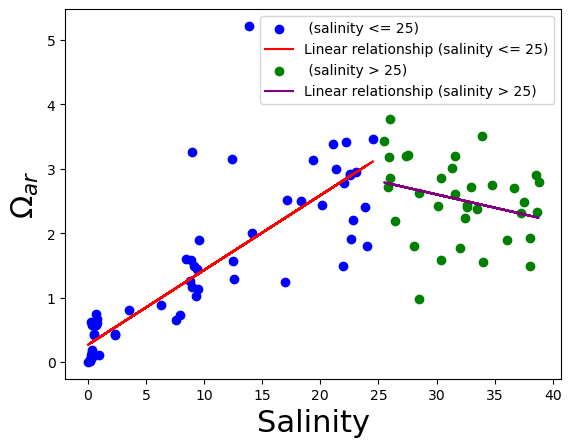

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def process_segment(salinity, saturation_aragonite, mask, color_data, color_fit, label):
    # Segment the data
    salinity_seg, saturation_aragonite_seg = salinity[mask], saturation_aragonite[mask]

    # Calculate the coefficients of the linear relationship
    coefficients = np.polyfit(salinity_seg, saturation_aragonite_seg, 1)

    # Generate y-values based on the linear relationship
    y_values = coefficients[0] * salinity_seg + coefficients[1]

    # Calculate the correlation coefficient
    r_squared = np.corrcoef(salinity_seg, saturation_aragonite_seg)[0,1]**2

    # Print the R-squared value
    print(f"The rR-squared value for {label} is: {r_squared}")
   
   # print the intercept and its uncertainty
    slope, intercept, r_value, p_value, std_err = stats.linregress(salinity_seg, saturation_aragonite_seg)
    print(f"The intercept for {label} is: {intercept} and its uncertainty is: {std_err}")
    
   

    # Plot the original data as scatter plot
    plt.scatter(salinity_seg, saturation_aragonite_seg, color=color_data, label=f" {label}")

    # Plot the linear relationships
    plt.plot(salinity_seg, y_values, color=color_fit, label=f"Linear relationship {label}")
    

# Assuming you have two arrays salinity and saturation_aragonite
salinity = np.array(terminos_inorganic_carbon_results["salinity"])
saturation_aragonite = np.array(terminos_inorganic_carbon_results["saturation_aragonite"])

mask_salinty_value = 25

# Segment the data into two sections
mask = salinity <= mask_salinty_value

# Process each segment
process_segment(salinity, saturation_aragonite, mask, 'blue', 'red', f'(salinity <= {mask_salinty_value})')
process_segment(salinity, saturation_aragonite, ~mask, 'green', 'purple', f'(salinity > {mask_salinty_value})')

plt.xlabel('Salinity', fontsize = 22)
plt.ylabel('$\Omega_{ar}$',     fontsize =22)
plt.legend()

plt.savefig('../output_files/sal_omega.tiff', dpi=600, bbox_inches='tight')

plt.show()

## **Conclusion the saturation of aragonite present a linear relationship with the salinity <= 25.**